## *Broken Compass*

[Official site.](https://twolittlemice.net/brokencompass/)

[*Household* quickstart.](https://www.drivethrurpg.com/product/421014/Household--Quickstart) At time of writing (December 2022) this uses the same rules.

### Basic mechanic

1. Roll a pool of between two and nine d6s.
2. Count matching sets.
    * 2-of-a-kind: Basic success (valued at 1 point).
    * 3-of-a-kind: Critical success (valued at 3 points).
    * 4-of-a-kind: Extreme success (valued at 9 points).
    * 5-of-a-kind: Impossible success (valued at 27 points).
    * 6-of-a-kind: What a Hero! (valued at 81 points).
3. Total up the points. (These point values reflect the "3X1" rule, though by the rules the exchange only goes one way.)
    * For purposes of plotting only. The point values reflect the "3X1" / "One for Three, Three for One!" rule.
    * In *Broken Compass* the trade can only combine lesser successes into a greater one, while in *Household* the trade can go in either direction.


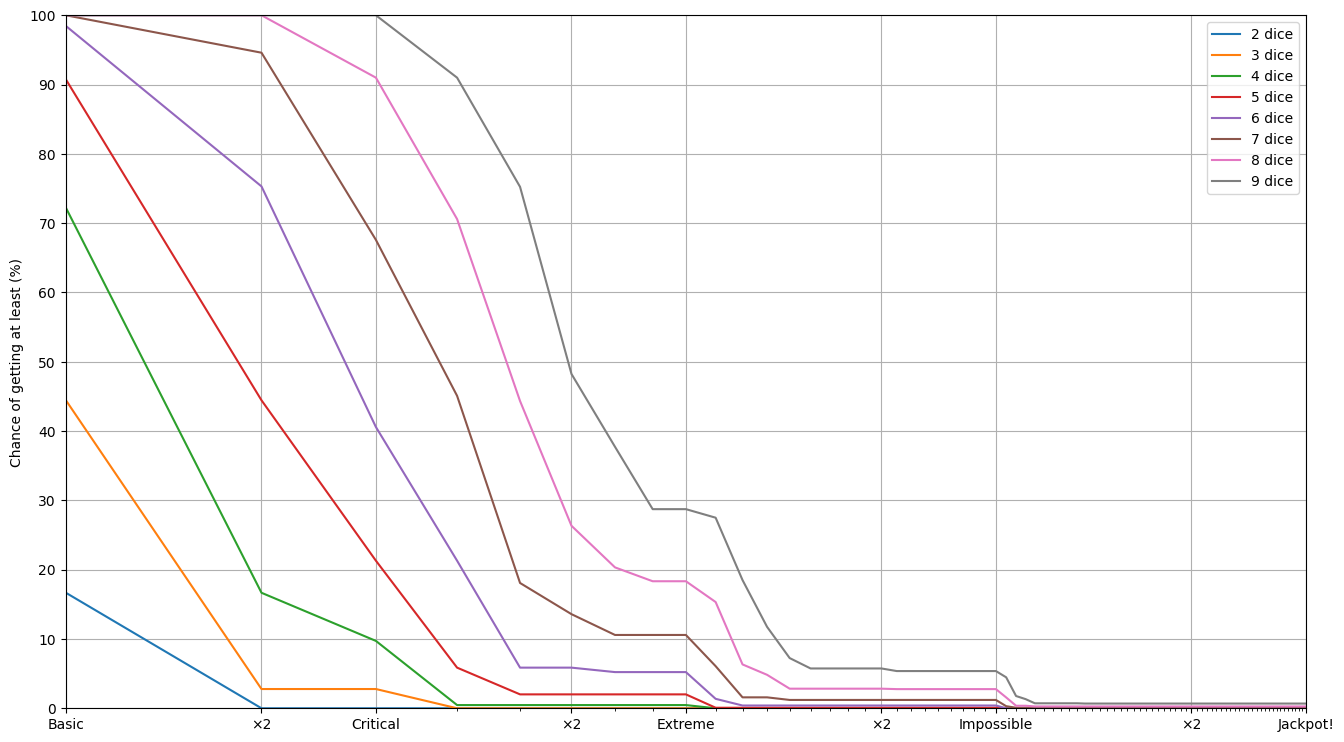

In [1]:
%pip install icepool

import icepool
from icepool import d6
import matplotlib.pyplot as plt

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
def score(counts):
    result = 0
    for count in counts:
        count = min(count, 6)
        if count >= 2:
            result += 3 ** (count - 2)
    return result

pool_sizes = [2, 3, 4, 5, 6, 7, 8, 9]

def plot_results(results, extra_results = None):
    figsize = (16, 9)
    fig, ax = plt.subplots(figsize=figsize)
    for result in results:
        ax.semilogx(range(82), [result.probability('>=', x, percent=True) for x in range(82)])
    if extra_results:
        for i, result in enumerate(extra_results):
            ax.semilogx(range(82), [result.probability('>=', x, percent=True) for x in range(82)],
                       color=default_colors[i], linestyle='--', alpha=0.5)
    ax.legend([f'{pool_size} dice' for pool_size in pool_sizes])
    ax.set_xticks([1, 2, 3, 6, 9, 18, 27, 54, 81])
    ax.set_xticklabels(['Basic', '×2', 'Critical', '×2', 'Extreme', '×2', 'Impossible', '×2', 'Jackpot!'])
    ax.set_xticks(range(1, 91), minor=True)
    ax.set_xticklabels([], minor=True)
    ax.set_yticks(range(0, 101, 10))
    ax.set_xlim(1, 81)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Chance of getting at least (%)')
    ax.grid()
    plt.show()

results = []

for pool_size in pool_sizes:
    initial = d6.pool(pool_size).all_counts(filter=0)
    result = initial.map(score)
    results.append(result)

plot_results(results)


### Rerolling

* The character can potentially reroll up to two times.
* If the character goes for the reroll, all numbers that are not part of a success (i.e. only one of that number was rolled) are rerolled -- no more, no less.
* If the character rolled at least one success in the initial roll, they make take the first reroll ("Risk").
* If the first reroll does not add or improve any successes, they lose one of their existing successes (of their choice) and the roll is over.
* If the first reroll adds or improves at least one success, the character may either accept the result or make a second reroll ("All or Nothing" / "All In").
* If the second reroll does not add or improve any successes, all successes are lost.

We'll analyze two strategies:

1. "Known-difficulty": The difficulty is known; stop when that success level is reached.
2. "Always-reroll": Take every possible reroll, even at the risk of busting.

For known-difficulty, for any decision point, the highest difficulty reached is the max of the current roll (since the player can always choose to exit if the successes are sufficient) and the potential reroll (which the player will surely take otherwise). If the result of the roll is a binary pass/fail, knowing the target difficulty is as good as knowing exactly what numbers will come up on your rerolls!

For always-reroll, we just compute the result of the second reroll (if the reroll is available).

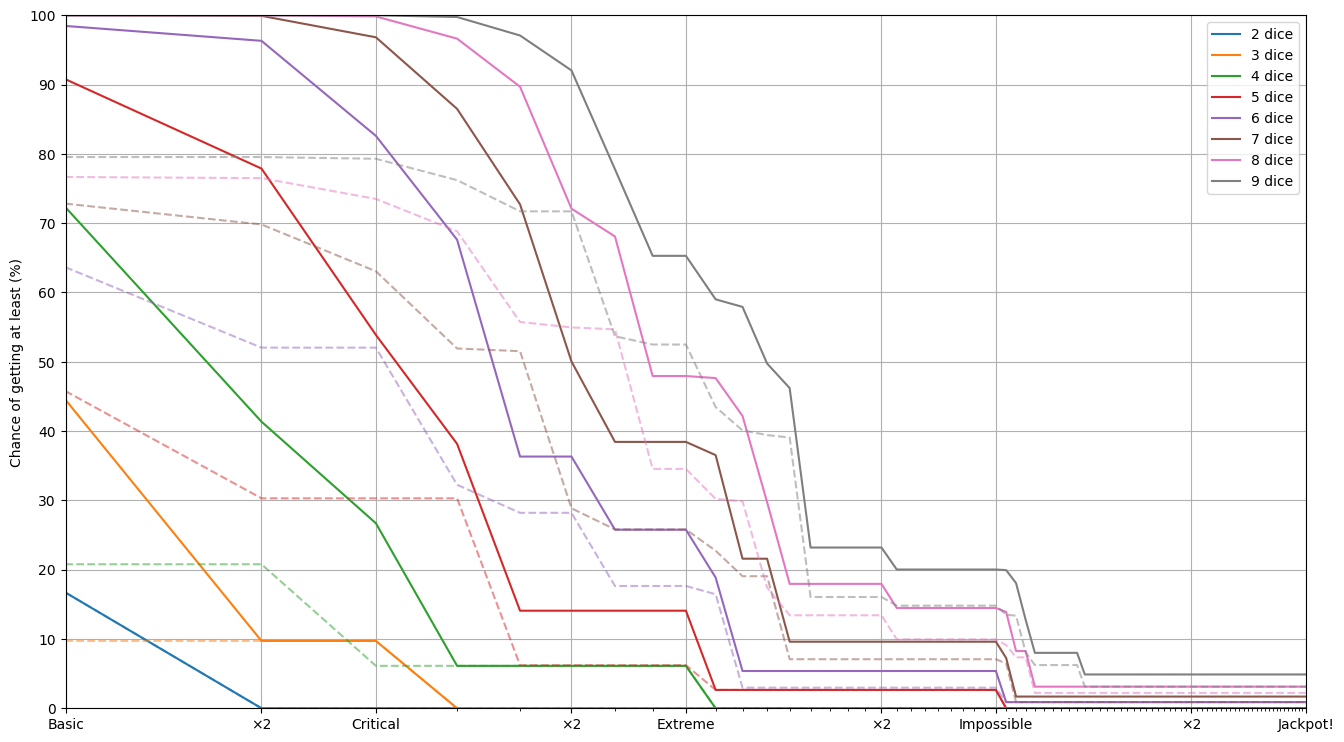

In [2]:
from functools import cache

die = icepool.one_hot(6)

@cache
def reroll(outcome):
    num_reroll = outcome.count(1)
    rerolled = num_reroll @ die
    not_rerolled = icepool.Vector(count if count >= 2 else 0 for count in outcome)
    after = rerolled + not_rerolled
    after.map(lambda x: icepool.Vector(sorted(x)))
    return after

@cache
def all_or_nothing_score(mid_outcome):
    mid_score = score(mid_outcome)
    
    if 1 not in mid_outcome:
        # Nothing to reroll.
        return mid_score
    
    final = reroll(mid_outcome)
    
    def final_score(aon_outcome):
        aon_score = score(aon_outcome)
        if aon_score > mid_score:
            return aon_score
        else:
            # Busted!
            return 0
    
    return final.map(final_score)

@cache
def known_difficulty_risk_score(risked_outcome, initial_score):
    risked_score = score(risked_outcome)
    if risked_score > initial_score:
        return icepool.highest(risked_score, all_or_nothing_score(risked_outcome))
    else:
        return initial_score

def known_difficulty_risk(initial_outcome):
    initial_score = score(initial_outcome)
    
    if initial_score == 0:
        # No reroll possible.
        return 0
    
    if 1 not in initial_outcome:
        # Nothing to reroll.
        return initial_score
    
    risked = reroll(initial_outcome)
    
    return risked.map(lambda x: known_difficulty_risk_score(x, initial_score))

@cache
def always_reroll_risk_score(risked_outcome, initial_score):
    risked_score = score(risked_outcome)
    if risked_score > initial_score:
        return all_or_nothing_score(risked_outcome)
    else:
        dropped = min(x for x in risked_outcome if x >= 2)
        return initial_score - score([dropped])

def always_reroll_risk(initial_outcome):
    initial_score = score(initial_outcome)
    
    if initial_score == 0:
        # No reroll possible.
        return 0
    
    if 1 not in initial_outcome:
        # Nothing to reroll.
        return initial_score
    
    risked = reroll(initial_outcome)
    
    return risked.map(lambda x: always_reroll_risk_score(x, initial_score))

known_difficulty_results = []
always_reroll_results = []

for pool_size in pool_sizes:
    initial = pool_size @ die
    known_difficulty_results.append(initial.map(known_difficulty_risk))
    always_reroll_results.append(initial.map(always_reroll_risk))

plot_results(known_difficulty_results, always_reroll_results)

The dotted lines represent the results of always-reroll, which can be thought of as the maximum penalty for taking risks.

Interestingly, there are a few places where extra dice appears to hurt the always-reroll strategy. My guess is that the extra dice can increase the chance of rolling well enough that it would be silly to continue, but always-reroll does so anyways.

### Expertise / Free Re-Roll

If the character has Expertise / Free Re-Roll in the task:

* They can make the first reroll even without successes in the initial roll.
* They don't lose any successes if the first reroll doesn't add or improve any success.
* They can make the second reroll ("All or Nothing" / "All In") even if the first reroll doesn't add or improve any success.

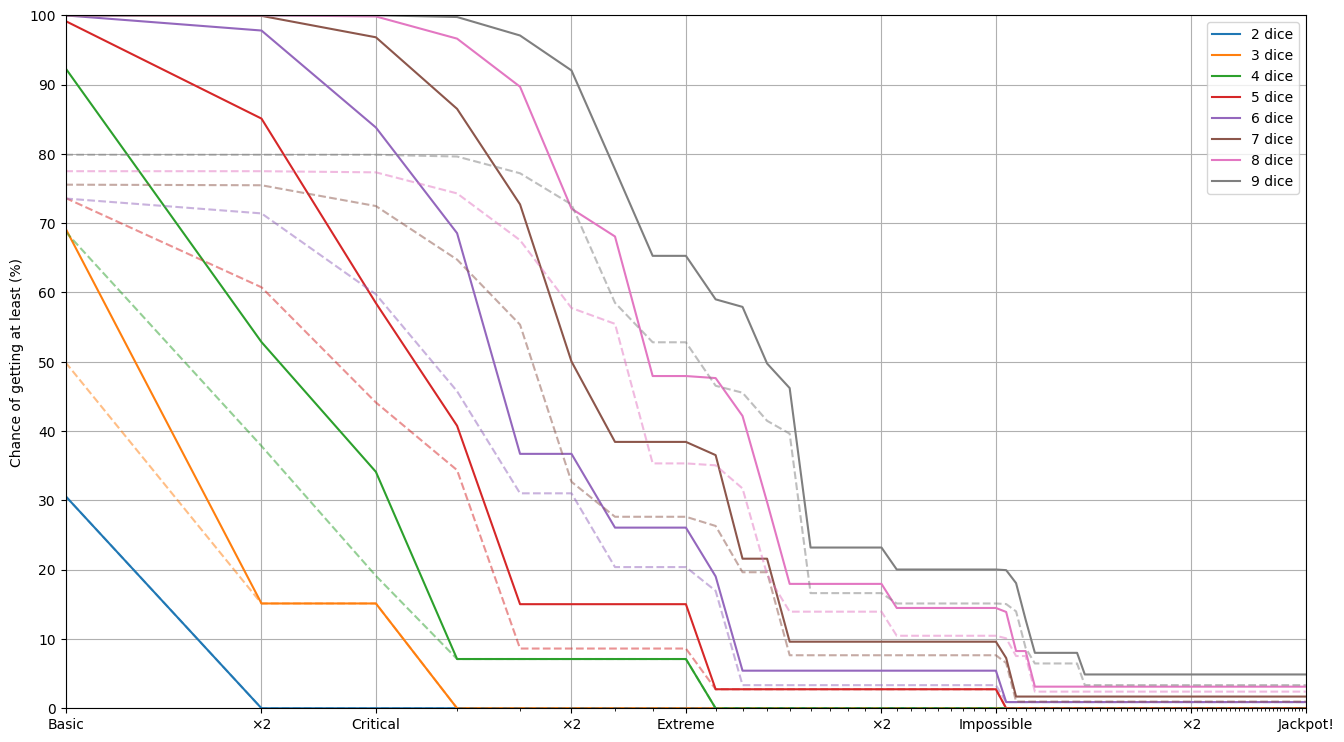

In [3]:
@cache
def known_difficulty_expert_score(risked_outcome, initial_score):
    risked_score = score(risked_outcome)
    if risked_score > initial_score:
        return icepool.highest(risked_score, all_or_nothing_score(risked_outcome))
    else:
        return initial_score

def known_difficulty_expert(initial_outcome):
    initial_score = score(initial_outcome)
    
    if 1 not in initial_outcome:
        # Nothing to reroll.
        return initial_score
    
    risked = reroll(initial_outcome)
    
    return risked.map(lambda x: known_difficulty_expert_score(x, initial_score))

@cache
def always_reroll_expert_score(risked_outcome, initial_score):
    risked_score = score(risked_outcome)
    if risked_score > initial_score:
        return all_or_nothing_score(risked_outcome)
    else:
        return initial_score

def always_reroll_expert(initial_outcome):
    initial_score = score(initial_outcome)
    
    if 1 not in initial_outcome:
        # Nothing to reroll.
        return initial_score
    
    risked = reroll(initial_outcome)
    
    return risked.map(lambda x: always_reroll_expert_score(x, initial_score))

known_difficulty_results = []
always_reroll_results = []

for pool_size in pool_sizes:
    initial = pool_size @ die
    known_difficulty_results.append(initial.map(known_difficulty_expert))
    always_reroll_results.append(initial.map(always_reroll_expert))

plot_results(known_difficulty_results, always_reroll_results)

For large pools and low target successes, always-reroll can perform worse than in the non-Expertise case! This is due to the increased possibility of bad bets on "All or nothing".